# Install dependencies

In [ ]:
#!pip install gensim

# Imports

In [1]:
import json
import gensim.downloader as api

#--- libs imported by kk
import nltk
from nltk.corpus import stopwords
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import pdb
import numpy as np
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.rcParams['text.usetex'] = True
import warnings
warnings.filterwarnings('ignore')


In [2]:
#--- aux functions

def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None, density=True,**kwargs):
    '''
    return pdf
    '''
    if 'bins' in kwargs:
        bins = kwargs['bins'] 
    elif not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        assert not 'bins' in kwargs and linscale
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)

    bins = kwargs['bins'] if 'bins' in kwargs else bins
        
    hist, edges = np.histogram(slist,bins=bins,density=density)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    if density:
    	nth=1   
    	hist = hist[count>nth]
    	edges = edges[:-1][count>nth]
    	count = count[count>nth]
    else:
        count=1

    return  hist, edges, hist / count**0.5


def PltErr( xdata, ydata, 
            yerr = None,
            xstr = '',
            ystr = '',
            Plot = True,
            **kwargs
            ):
    '''
    plot data
    '''
    fontsize=kwargs['fontsize'] if 'fontsize' in kwargs else 20
    if not 'ax' in kwargs:
        fig = plt.figure( figsize = (4,4) if 'figsize' not in kwargs else kwargs['figsize'] )
        ax = fig.add_subplot(111)
#        ax.count = 0
        ax.markerss=['o','s','D','^','<','>','v']

#        ax.set_prop_cycle(marker=['o', '+', 'x', '*', '.', 'X'])
    else:
        ax = kwargs['ax']
#        ax.count += 1

        if 'twinx' in kwargs and kwargs['twinx']:
                ax = kwargs['ax'].twinx()
    #--- setting   
    ax.set_xlabel(xstr,fontsize=fontsize)
    ax.set_ylabel(ystr,fontsize=fontsize)
    ax.tick_params(labelsize=fontsize,which='both',axis='both', top=True, right=True)
    #
    xerr = kwargs['xerr'] if 'xerr' in kwargs else None 
#
    if 'attrs' in kwargs:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, **kwargs['attrs'])
        if 'fill_between' in kwargs and kwargs['fill_between']:
            ax.fill_between(xdata, ydata-yerr, ydata+yerr)
    else:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr,
                    fmt=kwargs['fmt'] if 'fmt' in kwargs else '-o',
                    label=kwargs['label'] if 'label' in kwargs else '',
                    markevery=kwargs['markevery'] if 'markevery' in kwargs else 1,
                    markersize=kwargs['markersize'] if 'markersize' in kwargs else 10,
                    marker=kwargs['marker'] if 'marker' in kwargs else 'o', #ax.markerss[(ax.count)%7],
                   )

    #--- plot
    #
#    ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
    #
    if 'ylim' in kwargs:
        ylim = kwargs['ylim'] 
        ax.set_ylim(ylim)
    if 'xlim' in kwargs:
        xlim = kwargs['xlim'] 
        ax.set_xlim(xlim)
    #
    if 'xscale' in kwargs: 
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs: 
        ax.set_yscale(kwargs['yscale'])
    #
    if 'xticks' in kwargs:
        ax.set_xticks(list(map(float,kwargs['xticks'][1])))
#        ax.set_xticklabels(list(map(lambda x:'$%s$'%x,kwargs['xticks'][0])))
        ax.set_xticklabels(kwargs['xticks'][0])
    #
    if 'yticks' in kwargs:
        ax.set_yticks(list(map(float,kwargs['yticks'][1])))
        ax.set_yticklabels(list(map(lambda x:'$%s$'%x,kwargs['yticks'][0])))
        
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    ndecade_x = kwargs['ndecade_x'] if 'ndecade_x' in kwargs else 1
    ndecade_y = kwargs['ndecade_y'] if 'ndecade_y' in kwargs else 1
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY,nevery_x=ndecade_x,nevery_y=ndecade_y)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'],LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs:
        plt.legend(**kwargs['legend'])
	#
    if 'halfopen' in kwargs and kwargs['halfopen']:
        ax.spines['right'].set_visible(False) #--- half open
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

    if 'title' in kwargs: #Plot:
        plt.savefig(kwargs['title'],dpi=300 if not 'dpi' in kwargs else kwargs['dpi'],bbox_inches='tight', 
                    pad_inches=0.0)
    if Plot:
        plt.show()
    #
    
    
#    if not 'ax' in kwargs:
    return ax


class Symbols:
    '''
    plot settings for matplotlib
    '''
    
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,**kwargs):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5 if not 'capsize' in kwargs else kwargs['capsize'],
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    '''
    legend settings for matplolib
    '''
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

def PutMinorTicks(ax, LOGY=None,LOGX=None, nevery_x=1,nevery_y=1):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[2]))
        ymax=np.floor(np.log10(ax.axis()[3]))
        nbin = ymax - ymin
        ax.set_yticks(10**np.arange(ymin,ymax+nevery_y,nevery_y))
#        ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if LOGX:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[0]))
        ymax=np.floor(np.log10(ax.axis()[1]))
        nbin = ymax - ymin
        ax.set_xticks(10**np.arange(ymin,ymax+nevery_x,nevery_x))
#        ax.set_xticks(np.logspace(ymin,ymax,int(nbin)+1))
#        print(10**np.arange(ymin,ymax,nevery_x))
#        ax.set_xticks(np.logspace(ymin,ymax,int(nbin/nevery_x)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


# Load generated qa pairs

In [3]:
path = '../data'
with open("%s/generated_dataset_qa_from_sentences_n=2.json"%path, "r") as f:
    qa_dataset = json.load(f)


This is a list of generated questions and answers pairs in the following format. Each element in the list is a dictionary with a context as a key and list of qa pairs as values.

```
[
    context : [
        {
            Question: question,
            Answer: answer,
        },
        {
            ...
        },    
    ],
    context2 : [
        ....
    ],
]

```

In [4]:
qa_dataset[:2]

[{'This observed orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis, as seen in Fig. 6(b). The crystallographic phases, twinning, and orientation relationship will be discussed subsequently in more detail. 4 Discussion 4.1 Solidification and particle microstructure The microstructures of the rapidly solidified UNb particles display a clear dependence on particle size, as seen in Fig. 1.': [{'Question': ' What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?',
    'Answer': ' The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.'},
   {'Question': ' Is there a relationship between the microstructures of the rapidly solidified UNb particles and their particle size?',
    'Answer': 

To get only qa pairs do this:

In [5]:
qa_dataset[0].values()

dict_values([[{'Question': ' What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?', 'Answer': ' The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.'}, {'Question': ' Is there a relationship between the microstructures of the rapidly solidified UNb particles and their particle size?', 'Answer': ' Yes, the microstructures of the rapidly solidified UNb particles display a clear dependence on particle size.'}, {'Question': ' Will the crystallographic phases, twinning, and orientation relationship be discussed in more detail?', 'Answer': ' Yes, the crystallographic phases, twinning, and orientation relationship will be discussed subsequently in more detail.'}]])

In [6]:
all_qa_pairs = []
for data in qa_dataset:
    all_qa_pairs.extend(*data.values())

In [7]:
data.values()

dict_values([[{'Question': ' What was the sample cut for?', 'Answer': ' The sample was cut to observe the horizontal cross section.'}, {'Question': ' What was used to polish the sample?', 'Answer': ' Diamond paste was used to polish the sample.'}, {'Question': ' What was used to perform the B element analysis?', 'Answer': ' An electron probe micro analyzer-wavelength dispersive X-ray spectroscopy (EPMA-WDS) was used to perform the B element analysis.'}]])

Each qa pair is a dictionary with keys adequately named "Question" and "Answer"

In [8]:
all_qa_pairs[0:2]

[{'Question': ' What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?',
  'Answer': ' The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.'},
 {'Question': ' Is there a relationship between the microstructures of the rapidly solidified UNb particles and their particle size?',
  'Answer': ' Yes, the microstructures of the rapidly solidified UNb particles display a clear dependence on particle size.'}]

In [9]:
example_qa = all_qa_pairs[0]

print(f"Question: {example_qa['Question']}")
print(f"Answer: {example_qa['Answer']}")

Question:  What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?
Answer:  The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.


# Load Word2Vec

In [10]:
wv = api.load('word2vec-google-news-300')



Word2Vec is a ML model that encodes words into verctors (in this case 300 numbers long).

In [ ]:
vec_king = wv['king']

In [ ]:
vec_king.shape

In [ ]:
vec_king[:40]

You use this to find similar words

In [ ]:
wv.most_similar(positive=["queen"], topn=10)

Or find words with similar verctors you your word

In [ ]:
wv.most_similar(positive=[vec_king], topn=10)

You can even do some math on vectors and expect to have some correlation in how close those vectors get to vectors of known words

In [ ]:
vec_man = wv['man']
vec_woman = wv['woman']

In [ ]:
new_vec = vec_king - vec_man + vec_woman

Queen is more similar now then before.

In [ ]:
wv.most_similar(positive=[new_vec], topn=3)

Not all words are present in word2vec dictionary

In [ ]:
vec_cam = wv['cameroon']

However letter case matters here

In [ ]:
vec_cam = wv['Cameroon']

In this case you can either train new model with increased vocabulary or skip that word.

In [ ]:
for word in "Why is cameroon not in the vocabulary but Cameroon is ?".split():
    try:
        embedding = wv[word]
    except KeyError:
        print(f"No word {word} in vocabulary.")
        continue
    
    print(f"{word}: {embedding[:5]}.....")
    


And to get back to our data

In [ ]:
print(example_qa['Question'])
print()
example_question = example_qa['Question'].replace("?", " ?") # add space before "?" or we could remove it since it's not in the vocab anyway.

for word in example_question.split():
    try:
        embedding = wv[word]
    except KeyError:
        print(f"No word {word} in vocabulary.")
        continue
    
    print(f"{word}: {embedding[:5]}.....")
    


# Construct graphs

In [15]:
class GraphNetwork:
    '''
    Class for embedded-word graphs storing nodes with optional attributes
    
    Edges are represented as links between nodes with optional data.
    '''
    
    
    def __init__(self, wv, ndim, verbose=False):
        self.verbose = verbose
        self.wv = wv
        self.ndim = ndim
        self.sw_nltk = stopwords.words('english')

        pass
    
    
    def Embedding(self, word):
        '''
        word embedding using word2vec
        '''
        try:
            return self.wv[word]
        except KeyError:
            if self.verbose:
                print(f"No word {word} in vocabulary.")
            return np.array([np.nan]*self.ndim)
#             continue

    def ParseStringArrays(self, data):
        '''
        embedd array of strings in a vector space
        '''
        #--- positions in the embedded space
        self.position = np.concatenate(list(map(lambda x:self.ParseString(x),data)),axis=0)

        if self.verbose:
            print('position.shape:',self.position.shape)

        
        self.nnode = self.position.shape[0]
        
    def ParseString(self,strr):
        '''
        embedd string in a vector space

        '''
        #--- preprocess qa pair
        self.data_preprocessed = list(map(lambda x:self.Preprocess(x),strr))
        if self.verbose:
            print('qa pair:',strr)
            print('preprocessed qa pair:',self.data_preprocessed)


        #--- concat
        data_preprocessed = ' '.join(self.data_preprocessed)
        if self.verbose:
            print('concatenated qa:',data_preprocessed)

        #--- rm duplicates
        example_question_unique = list(set(data_preprocessed.split()))
        data_preprocessed = ' '.join(example_question_unique)
        if self.verbose:
            print('unique qa:',data_preprocessed)
#        words_unique = list(set(words))


        #--- embed in feature space
        position = np.c_[list(map(lambda x: self.Embedding(x),data_preprocessed.split()))]
        assert position.shape[1] == self.ndim, 'dimension of %s != %s'(data_preprocessed,self.ndim)
        
        #--- rm nan's
        position, filtr = GraphNetwork.RemoveNans(position)
        
        
        #--- return center of mass
#        center = np.mean(position[filtr],axis=0)
    
        #--- add noise
        GraphNetwork.Addnoise(position)
#        words = np.c_[list(map(lambda x:self.ParseString(x)[1],data))]
        
        #--- process        



#         self.nnode = self.position.shape[0]
        self.labels = np.array(data_preprocessed.split())[filtr]
    
        
        
        return position #[filtr] # , example_question[filtr] #[filtr], np.array(example_question_unique)[filtr]
        
    def BuildGraph(self,thresh=1e-1):
        '''
        construct a geometric graph
        '''
        dim=self.ndim
        w = {i: 0.5 for i in range( self.nnode ) }
        self.graph = nx.geographical_threshold_graph(self.nnode, 1.0/thresh,dim=dim,
                                                     pos=self.position, weight=w)
        
        #--- relabel graph
        nodes = self.graph.nodes
        mapping = dict(zip(nodes,self.labels))
        self.graph = nx.relabel_nodes(self.graph, mapping)
        
        #--- add edges
        assert len(self.graph.edges) == 0, 'decrease threshold!'
        list(map(lambda x:self.AddEdge(x.split()),self.data_preprocessed))

    def PlotGraph(self):
        '''
        plot grpahs
        '''
        
#         edge_list = np.array(self.graph.edges())
#         inv_distance = np.log10(np.array(list(map(lambda x:1/self.distance_matrix[x[0],x[1]],edge_list))))
#         xmin = np.min(inv_distance)
#         xmax = np.max(inv_distance)
#         inv_distance -= xmin
#         inv_distance /= (xmax-xmin)
        
        #--- only connected nodes
#        nodelist = list(set(edge_list.flatten()))
        
        #--- plot
        subax1 = plt.subplot(111)
        nx.draw_networkx(self.graph,pos=dict(zip(self.graph.nodes,self.position[:,0:2])),
#                   labels=dict(zip(range(self.nnode),self.labels)),
                with_labels=True, 
                 font_weight='bold',
#                          nodelist=nodelist,
                         node_color='yellow',
                         linewidths=0.5,
                         font_size=8.0,
#                          width = inv_distance, #(inv_distance-xmin)/(xmax-xmin),
#                          edge_vmin=0,edge_vmax=1, 
#               font_size=8,
#                node_size=30,
               )
        
        #--- plot edge labels
#         edge_tuples = list(map(lambda x:(x[0],x[1]),edge_list))
#         inv_distance_str = list(map(lambda x:'%3.2f'%x,inv_distance))
#         edge_labels = dict(zip(edge_tuples,inv_distance_str))
#         nx.draw_networkx_edge_labels(self.graph,pos=dict(zip(self.graph.nodes,self.position[:,0:2])),
# #                                     edge_labels=edge_labels,
#                                     font_color='red',
#                                      font_size=6,
#                                     )
        plt.savefig('png/graph.png',dpi=300)

    def DistanceMatrix(self):
        '''
        compute distance matrix
        '''
        self.distance_matrix = np.c_[list(map(lambda y:\
                              list(map(lambda x: GraphNetwork.Distance(x,self.position[y]) ,self.position)), range(self.nnode)))]
        
    def PlotPairDistance(self,rcut=1.0):
        '''
        distance distribution
        '''
        rij = np.concatenate(list(map(lambda x:self.distance_matrix[x,x+1:],range(self.nnode))))
        hist, bin_edges, err = GetPDF(rij[rij>=rcut], n_per_decade=32)

        !mkdir png
        PltErr(bin_edges,hist,
                  yerr=err,
                   xscale='log',yscale='log',
                   xstr='distance',ystr='probability',
                   title='png/pairwise_distance_distribution.png',
                   xlim=(1e-1,100),
                  )
        
    def PlotDegree(self):
        '''
        degree distribution
        '''
        degrees = np.array([self.graph.degree(n) for n in self.graph.nodes()])
        filtr = degrees > 0
        hist, bin_edges, err = GetPDF(degrees[filtr], n_per_decade=16)

#         np.savetxt('png/degree2.txt',np.c_[hist, bin_edges, err])
        PltErr(bin_edges,hist,
                  yerr=err,
                   xscale='log',yscale='log',
                    xstr='degree',ystr='probability',
                   title='png/degree_distribution.png',
                  )

    def AddEdge(self,question):
        #--- edge tuples
        edge_tuples=list(zip(question,question[1:]))
        self.graph.add_edges_from(edge_tuples)  # using a list of edge tuples
        #--- remove newly-added nodes
        nodes = np.array(list(self.graph.nodes.keys()))
        filtr = list(map(lambda x:len(self.graph.nodes[x])==0,nodes))
        self.graph.remove_nodes_from(nodes[filtr])

    
    
    @staticmethod
    def Distance(xi,xj):
        return np.sum((xi-xj)**2)

    @staticmethod
    def withinThreshold(G, thresh):
        for item in G.edges():
            xi = pos[item[0]]
            xj = pos[item[1]]
            dist = GraphNetwork.Distance(xi,xj)
            assert dist <= thresh, '%s <= %s!'%(dist,thresh)
            
    @staticmethod
    def Replace(strr):
        strr = strr.replace("?", " ?")
        strr = strr.replace(".", " .")
        strr = strr.replace(",", " ,")
        return strr
        
    def Preprocess(self,text):
        #--- replace
#        data_replaced_qmark = list(map(lambda x:GraphNetwork.Replace(x),data))
        text_replaced_qmark = GraphNetwork.Replace(text)
        #--- concat
#        data_concat = np.concatenate(list(map(lambda x:x.split(),data_replaced_qmark)))
        
        #--- rm duplicates
#        data_unique = list(set(data_concat))

        #--- rm stop words
        words = [word for word in text_replaced_qmark.split() if word.lower() not in self.sw_nltk]
        new_text = " ".join(words)

        
        return new_text
    
    @staticmethod
    def RemoveNans(array):
        filtr = ~np.any(np.isnan(array),axis=1)
        return array[filtr], filtr

    @staticmethod
    def Addnoise(position):
        noise = np.random.normal(size=position.size,
                scale=1e-6).reshape(position.shape)
        position += noise


qa pair: (' What is the orientation relationship between the dendrite core and the interdendritic region in the solidified UNb particles?', ' The orientation relationship results in the dendrite core being slightly off of the [ 10 1 ¯ ] zone axis when the interdendritic region is tilted to the [ 1 ¯ 32 ] zone axis.')
preprocessed qa pair: ['orientation relationship dendrite core interdendritic region solidified UNb particles ?', 'orientation relationship results dendrite core slightly [ 10 1 ¯ ] zone axis interdendritic region tilted [ 1 ¯ 32 ] zone axis .']
concatenated qa: orientation relationship dendrite core interdendritic region solidified UNb particles ? orientation relationship results dendrite core slightly [ 10 1 ¯ ] zone axis interdendritic region tilted [ 1 ¯ 32 ] zone axis .
unique qa: relationship core orientation solidified UNb 10 ? [ particles ¯ ] 1 interdendritic region results . zone dendrite slightly axis 32 tilted
No word UNb in vocabulary.
No word 10 in vocabulary.

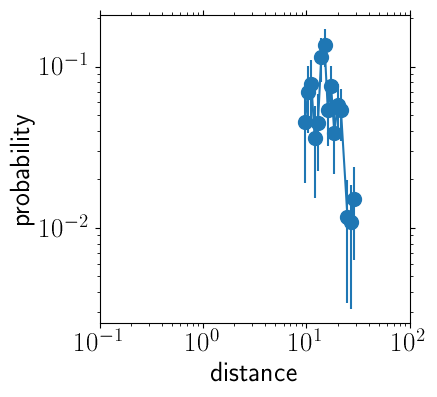

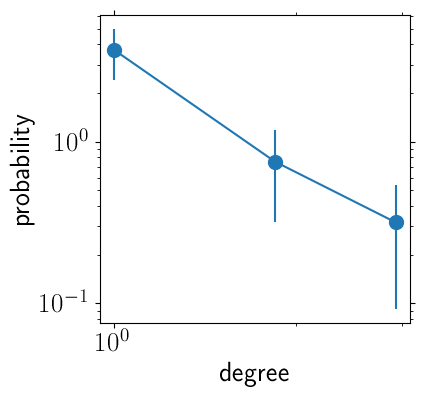

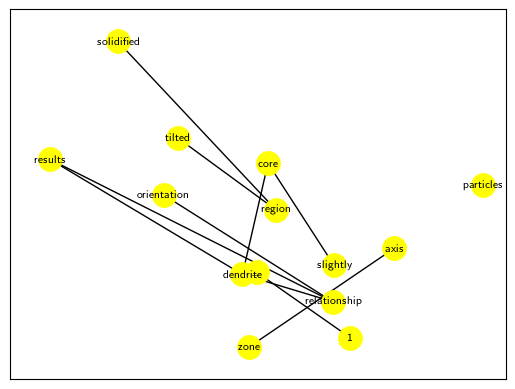

In [26]:
def main():
    
    #--- create qa pairs
    all_qa_pairs = []
    for data in qa_dataset:
        all_qa_pairs.extend(*data.values())

    #--- dictionary of q&a's
    qa_dict = {}
    for item in all_qa_pairs:
        if not 'Question' in item:
            continue
        qa_dict.setdefault(item['Question'],[]).append(item['Answer'])
        
    qa_tuples = list(map(lambda x: (x,qa_dict[x][0]), qa_dict.keys()))
    
    #--- setup your graph
    gn = GraphNetwork(wv,
                      300,
                         verbose=True,
                     )
    gn.ParseStringArrays(
         qa_tuples[:1],
#      [(' What flavour ice cream do you prefer?','I like chocolate ice cream.')],
#      [('what cream?','I chocolate.')],
    )
    gn.BuildGraph(thresh=1e-10)
    gn.DistanceMatrix()
    gn.PlotPairDistance(0.001)
    gn.PlotDegree()
    gn.PlotGraph()

    return qa_tuples, gn
qa_tuples, gn = main()

In [30]:
gn.graph.degree('particles')

0

In [31]:
help(nx.average_degree_connectivity)

Help on function average_degree_connectivity in module networkx.algorithms.assortativity.connectivity:

average_degree_connectivity(G, source='in+out', target='in+out', nodes=None, weight=None)
    Compute the average degree connectivity of graph.
    
    The average degree connectivity is the average nearest neighbor degree of
    nodes with degree k. For weighted graphs, an analogous measure can
    be computed using the weighted average neighbors degree defined in
    [1]_, for a node `i`, as
    
    .. math::
    
        k_{nn,i}^{w} = \frac{1}{s_i} \sum_{j \in N(i)} w_{ij} k_j
    
    where `s_i` is the weighted degree of node `i`,
    `w_{ij}` is the weight of the edge that links `i` and `j`,
    and `N(i)` are the neighbors of node `i`.
    
    Parameters
    ----------
    G : NetworkX graph
    
    source :  "in"|"out"|"in+out" (default:"in+out")
       Directed graphs only. Use "in"- or "out"-degree for source node.
    
    target : "in"|"out"|"in+out" (default:"in+out

In [23]:
#gn.graph.add_node(1, label='xxx')
dir(nx)



['AmbiguousSolution',
 'ArborescenceIterator',
 'DiGraph',
 'EdgePartition',
 'ExceededMaxIterations',
 'Graph',
 'GraphMLReader',
 'GraphMLWriter',
 'HasACycle',
 'LCF_graph',
 'LFR_benchmark_graph',
 'MultiDiGraph',
 'MultiGraph',
 'NetworkXAlgorithmError',
 'NetworkXError',
 'NetworkXException',
 'NetworkXNoCycle',
 'NetworkXNoPath',
 'NetworkXNotImplemented',
 'NetworkXPointlessConcept',
 'NetworkXTreewidthBoundExceeded',
 'NetworkXUnbounded',
 'NetworkXUnfeasible',
 'NodeNotFound',
 'NotATree',
 'PlanarEmbedding',
 'PowerIterationFailedConvergence',
 'SpanningTreeIterator',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_dispatch',
 '_lazy_import',
 'adamic_adar_index',
 'add_cycle',
 'add_path',
 'add_star',
 'adjacency',
 'adjacency_data',
 'adjacency_graph',
 'adjacency_matrix',
 'adjacency_spectrum',
 'adjlist',
 'algebraic_connectivity',
 'algebraicconnectivity',
 'algorithms',
 

In [21]:
gn.graph.edges

EdgeView([('relationship', 'orientation'), ('relationship', 'dendrite'), ('relationship', 'results'), ('core', 'dendrite'), ('core', 'slightly'), ('solidified', 'region'), ('¯', '1'), ('region', 'tilted'), ('results', 'dendrite'), ('zone', 'axis')])

In [ ]:
data0=np.loadtxt('png/degree0.txt')
data1=np.loadtxt('png/degree1.txt')
data2=np.loadtxt('png/degree2.txt')

symbols = Symbols()
legends = Legends()
legends.Set()

ax = PltErr(None,None,Plot=False)

hist, bin_edges, err = data0.T
PltErr(bin_edges,hist,
          yerr=err,
           attrs=symbols.GetAttrs(count=0, label=r'$0.6$'),
           ax=ax,
           Plot=False,
          )

hist, bin_edges, err = data1.T
PltErr(bin_edges,hist,
          yerr=err,
           attrs=symbols.GetAttrs(count=1,label=r'$0.8$'),
           ax=ax,
           Plot=False,
          )

hist, bin_edges, err = data2.T
PltErr(bin_edges,hist,
          yerr=err,
           attrs=symbols.GetAttrs(count=2,label=r'$1.0$'),
           ax=ax,
           Plot=False,
          )

PltErr(None,None,
           xscale='log',yscale='log',
            xstr='degree',ystr='probability',
           title='png/degree_distribution.png',
            ax=ax,
           legend=legends.Get()
          )